In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import kornia
from tqdm.auto import tqdm
from skimage import filters, exposure

import utilities
import GCC_Preprocess as gpp
import pyHREBSD
import rotations

%matplotlib widget


def view(*imgs, cmap='gray', titles=None):
    n = len(imgs)
    fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
    if n == 1:
        axes = [axes]
    for i, img in enumerate(imgs):
        ax = axes[i]
        ax.imshow(img, cmap=cmap)
        ax.axis('off')
        if titles is not None:
            ax.set_title(titles[i])
    plt.tight_layout()
    plt.show()

In [2]:
import os
import numpy as np
from collections import namedtuple
import re
import struct


NUMERIC = r"[-+]?\d*\.\d+|\d+"


def convert_pc(PC: tuple, N: tuple, delta: float, b: float = 1.0) -> tuple:
    """
    Converts the pattern center from EDAX/TSL standard to the EMsoft standard
    Input:
        PC: tuple of floats (xstar, ystar, zstar)
        Nsy: tuple, detector dimensions before binning
        delta: float, the detector pixel size
        b: 
    Output:
        PC: tuple of floats (xpc, ypc, L)"""
    xpc = np.around(N[0] * (PC[0] - 0.5), 4)
    ypc = np.around(N[0] * PC[1] - b * N[1] * 0.5, 4)
    L = np.around(N[0] * delta * PC[2], 4)
    return (xpc, ypc, L)


def read_up2(up2: str) -> namedtuple:
    """Read in patterns and a pattern center from an ang file and a pattern file.
    Only supports a up2 file using the EDAX/TSL convention.

    Args:
        up2 (str): Path to the pattern file.

    Returns:
        namedtuple: Pattern file object with fields patshape, filesize, nPatterns, and datafile.
                    patshape is a tuple of the pattern dimensions.
                    filesize is the size of the pattern file.
                    nPatterns is the number of patterns in the file.
                    datafile is the file object to read the patterns."""
    # Get patterns
    upFile = open(up2, "rb")
    chunk_size = 4
    tmp = upFile.read(chunk_size)
    FirstEntryUpFile = struct.unpack('i', tmp)[0]
    tmp = upFile.read(chunk_size)
    sz1 = struct.unpack('i', tmp)[0]
    tmp = upFile.read(chunk_size)
    sz2 = struct.unpack('i', tmp)[0]
    tmp = upFile.read(chunk_size)
    bitsPerPixel = struct.unpack('i', tmp)[0]
    sizeBytes = os.path.getsize(up2) - 16
    sizeString = str(round(sizeBytes / 1e6, 1)) + " MB"
    bytesPerPixel = 2
    nPatternsRecorded = int((sizeBytes/bytesPerPixel) / (sz1 * sz2))
    out = namedtuple("up2_file", ["patshape", "filesize", "nPatterns", "datafile"])
    out = out((sz1, sz2), sizeString, nPatternsRecorded, upFile)
    return out


def read_ang(path: str) -> namedtuple:
    """Reads in the pattern center from an ang file.
    Only supports EDAX/TSL.

    Args:
        ang (str): Path to the ang file."""
    header_lines = 0
    with open(path, "r") as ang:
        for line in ang:
            if "x-star" in line:
                xstar = float(re.findall(NUMERIC, line)[0])
            elif "y-star" in line:
                ystar = float(re.findall(NUMERIC, line)[0])
            elif "z-star" in line:
                zstar = float(re.findall(NUMERIC, line)[0])
            elif "NROWS" in line:
                rows = int(re.findall(NUMERIC, line)[0])
            elif "NCOLS_ODD" in line:
                cols = int(re.findall(NUMERIC, line)[0])
            elif "COLUMN_HEADERS" in line:
                names = line.replace("\n", "").split(":")[1].strip().split(", ")
            elif "HEADER: End" in line:
                break
            header_lines += 1

    # Package the header data
    PC = (xstar, ystar, zstar)
    shape = (rows, cols)
    names.extend(["eulers", "quats", "shape", "pc"])
    names = [name.replace(" ", "_").lower() for name in names if name.lower() not in ["phi1", "phi", "phi2"]]

    # Read in the data
    ang_data = np.genfromtxt(path, skip_header=header_lines)
    ang_data = ang_data.reshape(shape + (ang_data.shape[1],))
    euler = ang_data[..., 0:3]
    ang_data = ang_data[..., 3:]
    qu = rotations.eu2qu(euler)
    ang_data = np.moveaxis(ang_data, 2, 0)

    # Package everything into a namedtuple
    ang_data = namedtuple("ang_file", names)(*ang_data, eulers=euler, quats=qu, shape=shape, pc=PC)
    return ang_data


def get_scan_data(up2: str, ang: str, Nxy: tuple, pixel_size: float = 10.0, calculate_sharpness: bool = False) -> tuple:
    """Reads in patterns and orientations from an ang file and a pattern file.
    Only supports EDAX/TSL.
    
    Args:
        up2 (str): Path to the pattern file.
        ang (str): Path to the ang file.
        Nxy (tuple): The detector dimensions before binning. Used for converting the pattern center.
        pixel_size (float): The detector pixel size. Used for converting the pattern center.
        calculate_sharpness (bool): Whether to calculate the sharpness of the patterns.

    Returns:
        np.ndarray: The patterns.
        namedtuple: The orientations. namedtuple with fields corresponding to the columns in the ang file + eulers, quats, shape, pc.
                    Sharpness replaces image quality (iq) if calculate_sharpness is True."""
    # Get the patterns
    ### TODO: Add lazy loading for large files
    pat_obj = read_up2(up2)

    # Get the ang data
    ang_data = read_ang(ang)

    # Convert the pattern center
    PC = convert_pc(ang_data.pc, Nxy, pixel_size)
    ang_data = ang_data._replace(pc=PC)

    return pat_obj, ang_data


def get_patterns(pat_obj: namedtuple, idx: np.ndarray | list | tuple = None) -> tuple:
    """Read in patterns from a pattern file object.
    
    Args:
        pat_obj (namedtuple): Pattern file object.
        idx (np.ndarray | list | tuple): Indices of patterns to read in. If None, reads in all patterns.

    Returns:
        np.ndarray: Patterns."""
    if idx is None:
        idx = range(pat_obj.nPatterns)

    # Read in the patterns
    pat_obj.datafile.seek(16)
    pats = np.zeros((len(idx), *pat_obj.patshape), dtype=np.uint16)
    for i in tqdm(range(len(idx)), desc="Reading patterns", unit="pats"):
        pat = idx[i]
        pat_obj.datafile.seek(pat * pat_obj.patshape[0] * pat_obj.patshape[1] * 2 + 16)
        pats[i] = np.frombuffer(pat_obj.datafile.read(pat_obj.patshape[0] * pat_obj.patshape[1] * 2), dtype=np.uint16).reshape(pat_obj.patshape)
    pats = pats.astype(np.float32)
    mins = pats.min(axis=(1, 2))[:, None, None]
    maxs = pats.max(axis=(1, 2))[:, None, None]
    pats = (pats - mins) / (maxs - mins)
    return pats




up2 = "E:/cells/CoNi90-OrthoCells.up2"
pat_obj = read_up2(up2)
print(pat_obj.filesize, pat_obj.patshape, pat_obj.nPatterns)
ang_data = read_ang("E:/cells/CoNi90-OrthoCells.ang")
idx = np.arange(np.prod(ang_data.shape)).reshape(ang_data.shape)
idx = idx.flatten()
pats = get_patterns(pat_obj).reshape((200, 200, *pat_obj.patshape))

5242.9 MB (256, 256) 40000


Reading patterns:   0%|          | 0/40000 [00:00<?, ?pats/s]

In [3]:
def get_sharpness(imgs: np.ndarray) -> np.ndarray:
    """Calculates the sharpness of an image/stack of images.
    
    Args:
        imgs (np.ndarray): The images to calculate the sharpness of. (H, W) or (N, H, W) or (N0, N1, H, W)

    Returns:
        np.ndarray: The sharpness of the images. float, (N,) or (N0, N1) for example."""
    # Process inputs
    reshape = None
    if imgs.ndim == 2:
        imgs = imgs[None, ...]
    elif imgs.ndim == 3:
        reshape = imgs.shape[:1]
    elif imgs.ndim == 4:
        reshape = imgs.shape[:2]
        imgs = imgs.reshape(-1, *imgs.shape[2:])

    # Convert to torch tensor, set device, create output tensor
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    imgs = torch.tensor(imgs, dtype=torch.float32).unsqueeze(1).to(device)
    shp = torch.zeros(imgs.shape[0], device=device)

    # Calculate sharpness
    for i in tqdm(range(imgs.shape[0]), desc='Calculating sharpness', unit='pats'):
        f = torch.fft.fft2(imgs[i])
        f = torch.real(f)
        f = torch.fft.fftshift(f)
        AF = torch.abs(f)
        M = AF.max()
        thresh = M / 2500
        th = (f > thresh).sum()
        shp[i] = th / (imgs.shape[2] * imgs.shape[3])

    # Convert to numpy and reshape if necessary
    shp = np.squeeze(shp.cpu().numpy())
    if reshape is not None:
        shp = shp.reshape(reshape)

    return shp


def clean_patterns(imgs: np.ndarray, equalize: bool = True, dog_sigmas: tuple = None) -> np.ndarray:
    """Cleans patterns by equalizing the histogram and normalizing.
    
    Args:
        pats (np.ndarray): The patterns to clean. (N, H, W)
        equalize (bool): Whether to equalize the histogram.

    Returns:
        np.ndarray: The cleaned patterns. (N, H, W)"""
    # Process inputs
    reshape = None
    if imgs.ndim == 2:
        imgs = imgs[None, ...]
    elif imgs.ndim == 3:
        reshape = imgs.shape[:1]
    elif imgs.ndim == 4:
        reshape = imgs.shape[:2]
        imgs = imgs.reshape(-1, *imgs.shape[2:])
    imgs = imgs.astype(np.float32).reshape(imgs.shape[0], 1, imgs.shape[1], imgs.shape[2])
    if dog_sigmas is None:
        bandpass = False
    else:    
        bandpass = True

    # Convert to torch tensor, set device, create output tensor
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    imgs = torch.tensor(imgs, dtype=torch.float32).to(device)

    # Subtract the background
    avg = imgs.mean(dim=(0), keepdim=True)
    background = kornia.filters.gaussian_blur2d(avg, (3, 3), (10.0, 10.0))
    imgs = imgs - background
    
    # Create processing functions
    def make_odd(x):
        return  x if x % 2 == 1 else x + 1
    def NONE(img):
        return img
    def equalize_func(img):
        equalized = kornia.enhance.equalize_clahe(img)
        out = kornia.enhance.normalize_min_max(equalized, 0.0, 1.0)
        return out
    def bandpass_func(img):
        kl = make_odd(int(dog_sigmas[0] * 3))
        kh = make_odd(int(dog_sigmas[1] * 3))
        low_pass = kornia.filters.gaussian_blur2d(img, (kl, kl), (dog_sigmas[0], dog_sigmas[0]))
        high_pass = kornia.filters.gaussian_blur2d(img, (kh, kh), (dog_sigmas[1], dog_sigmas[1]))
        out = kornia.enhance.normalize_min_max(low_pass - high_pass, 0.0, 1.0)
        return out
    def all_func(img):
        return equalize_func(bandpass_func(img))

    # Reshape into batches and process patterns
    imgs = imgs.reshape(-1, 4, 1, imgs.shape[2], imgs.shape[3])
    func = all_func if equalize and bandpass else equalize_func if equalize else bandpass_func if bandpass else NONE
    for i in tqdm(range(imgs.shape[0]), desc='Processing patterns', unit='pats'):
        imgs[i] = func(kornia.enhance.normalize_min_max(imgs[i], 0.0, 1.0))

    # Normalize
    out = imgs.cpu().numpy()
    out = out.reshape(-1, out.shape[3], out.shape[4])
    if reshape is not None:
        out = out.reshape(reshape + out.shape[1:])

    del imgs, background, avg
    torch.cuda.empty_cache()
    return out

In [4]:
pats_eq_blur = clean_patterns(pats[:100, :100], equalize=True, dog_sigmas=(1.0, 10.0))
pats_eq = clean_patterns(pats[:100, :100], equalize=True, dog_sigmas=None)
pats_blur = clean_patterns(pats[:100, :100], equalize=False, dog_sigmas=(1.0, 10.0))

shp_eq_blur = get_sharpness(pats_eq_blur)
shp_eq = get_sharpness(pats_eq)
shp_blur = get_sharpness(pats_blur)
shp = get_sharpness(pats[:100, :100])

c:\Users\lambj\miniconda3\envs\hrebsd\Lib\site-packages\kornia\filters\filter.py:129: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  output = F.conv2d(input, tmp_kernel, groups=tmp_kernel.size(0), padding=0, stride=1)


Processing patterns:   0%|          | 0/2500 [00:00<?, ?pats/s]

Processing patterns:   0%|          | 0/2500 [00:00<?, ?pats/s]

Processing patterns:   0%|          | 0/2500 [00:00<?, ?pats/s]

Calculating sharpness:   0%|          | 0/10000 [00:00<?, ?pats/s]

Calculating sharpness:   0%|          | 0/10000 [00:00<?, ?pats/s]

Calculating sharpness:   0%|          | 0/10000 [00:00<?, ?pats/s]

Calculating sharpness:   0%|          | 0/10000 [00:00<?, ?pats/s]

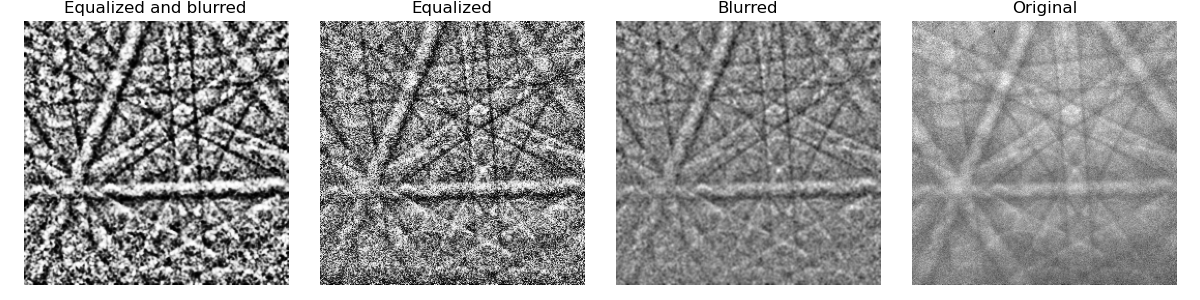

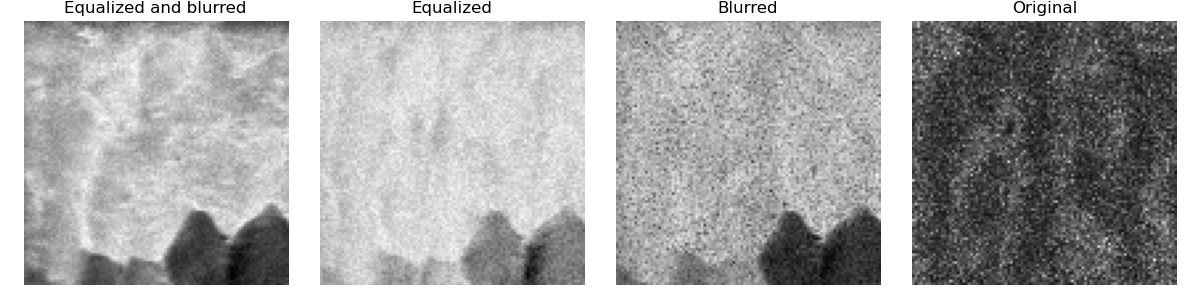

In [5]:
view(pats_eq_blur[0, 0], pats_eq[0, 0], pats_blur[0, 0], pats[0, 0], cmap='gray', titles=['Equalized and blurred', 'Equalized', 'Blurred', 'Original'])
view(shp_eq_blur, shp_eq, shp_blur, shp, titles=['Equalized and blurred', 'Equalized', 'Blurred', 'Original'])

In [ ]:
from scipy import signal

def test_bandpass(img):
    """Run bandpass filtering (using difference of gaussians) on an image.
    Do it for a range of lower and upper sigma values.
    Do vertical and horizontal stacking of the results to create on image (vertical axis is the high pass, horizontal is the low pass).
    For each image, also compute the fft and create the same composite image.
    
    Args:
        img (np.ndarray): The image to filter.
    
    Returns:
        np.ndarray: The composite image.
        np.ndarray: The fft composite image."""
    # Process inputs
    c = np.array(img.shape) // 2
    slc = (slice(c[0] - 64, c[0] + 64), slice(c[1] - 64, c[1] + 64))
    img = img[slc]
    low_sigmas = np.arange(0.25, 2.0, 0.25)  # high pass
    high_sigmas = np.arange(4.0, 11.0, 1.0)  # low pass
    composite = np.zeros((len(low_sigmas) * img.shape[0], len(high_sigmas) * img.shape[1]))
    composite_xcf = np.zeros((len(low_sigmas) * img.shape[0], len(high_sigmas) * img.shape[1]))
    window = (signal.windows.tukey(img.shape[0], alpha=0.4)[:, None] * signal.windows.tukey(img.shape[1], alpha=0.4)[None, :])
    sigmas = np.zeros((len(low_sigmas), len(high_sigmas), 2))
    for i, l in enumerate(low_sigmas):
        for j, h in enumerate(high_sigmas):
            image = filters.difference_of_gaussians(img, low_sigma=l, high_sigma=h)
            image = (image - image.min()) / (image.max() - image.min())
            # Apply a tukey hann window
            image = image * window
            image = exposure.equalize_adapthist(image)
            # Compute the cross-correlation
            xcf = signal.correlate2d(image, image, mode='same')
            composite[i*img.shape[0]:(i+1)*img.shape[0], j*img.shape[1]:(j+1)*img.shape[1]] = image
            composite_xcf[i*img.shape[0]:(i+1)*img.shape[0], j*img.shape[1]:(j+1)*img.shape[1]] = xcf
            sigmas[i, j] = (l, h)
    return composite, composite_xcf, sigmas
            
   
c, xcf, sigmas = test_bandpass(pats[112, 96])
print(sigmas[3, 6])
view(c, xcf, cmap='gray')

In [ ]:
im0 = pats[0, 0]
im1 = filters.difference_of_gaussians(im0, 1.0, 10.0)
im1 = (im1 - im1.min()) / (im1.max() - im1.min())
im2 = exposure.equalize_adapthist(im1, clip_limit=0.03)

im3 = filters.gaussian(im0, 1.0) - filters.gaussian(im0, 10.0)
im3 = (im3 - im3.min()) / (im3.max() - im3.min())
im4 = exposure.equalize_adapthist(im3, clip_limit=0.03)

view(im0, im1, im2, im3, im4, cmap='gray', titles=['Raw', 'DoG', 'DoG + Equalize', 'LoG', 'LoG + Equalize'])

In [ ]:
up2 = "E:/cells/CoNi90-OrthoCells.up2"
ang = "E:/cells/CoNi90-OrthoCells.ang"
pats, ang_data = utilities.get_scan_data(up2, ang, (2048, 2048), 13, calculate_sharpness=False)
# pats = utilities.clean_patterns(pats, equalize=True)
print("Number of patterns:", pats.shape[0]*pats.shape[1])
print("Pattern shape:", pats.shape[2:])
print("Grid:", pats.shape[:2])
print("Pattern center:", ang_data.pc)

In [ ]:
T = pats
R = pats[112, 96]
subset_slice = (slice(R.shape[0] // 2 - 64, R.shape[0] // 2 + 64),
                slice(R.shape[1] // 2 - 64, R.shape[1] // 2 + 64))
p0 = gpp.GCC_Initial_Guess(R, T)
np.save("p0_r112-96.npy", p0)
p = pyHREBSD.get_homography(R, T, subset_slice=subset_slice, p0=p0, max_iter=50, conv_tol=1e-7)
np.save("p_r112-96.npy", p)
p0 = np.load("p0_r112-96.npy")
p = np.load("p_r112-96.npy")

In [ ]:
R = pats[112, 96]
T = pats[112-50:112+50, 96-50:96+50]

subset_slice = (slice(10, R.shape[0] - 10),
                slice(10, R.shape[1] - 10))

p0 = gpp.get_initial_guess(R, T)
np.save("p0_r112-96-small.npy", p0)

p = pyHREBSD.get_homography(R, T, subset_slice=subset_slice, p0=p0, max_iter=50, conv_tol=1e-7)
np.save("p_r112-96.npy-small", p)

# p0 = np.load("p0_r112-96.npy")
# p = np.load("p_r112-96.npy")


In [ ]:
Fe = pyHREBSD.homography_to_elastic_deformation(p, ang_data.pc)
e, w = pyHREBSD.deformation_to_strain(Fe)

W = np.zeros_like(Fe)
W0 = np.zeros_like(Fe)
for i in range(Fe.shape[0]):
    for j in range(Fe.shape[1]):
        W[i, j] = pyHREBSD.W(p[i, j])
        W0[i, j] = pyHREBSD.W(p0[i, j])

In [ ]:
def view_tensor_images(e, cmap="jet", tensor_type="strain", xy=None):
    if tensor_type == "strain":
        var = r"$\epsilon$"
    elif tensor_type == "rotation":
        var = r"$\omega$"
    elif tensor_type == "deformation":
        var = r"$F$"
    fig, ax = plt.subplots(3, 3, figsize=(12.2, 12))
    plt.subplots_adjust(wspace=0.35, hspace=0.01, left=0.01, right=0.93, top=0.99, bottom=0.01)
    for i in range(3):
        for j in range(3):
            _0 = ax[i, j].imshow(e[..., i, j], cmap=cmap, vmin=-abs(e[..., i, j]).max(), vmax=abs(e[..., i, j]).max())
            ax[i, j].axis('off')
            ax[i, j].set_title(var + r"$_{%i%i}$" % (i+1, j+1))
            if xy is not None:
                ax[i, j].plot(xy[1], xy[0], 'kx', markersize=10)
            loc = ax[i, j].get_position()
            cax = fig.add_axes([loc.x1 + 0.01, loc.y0, 0.01, loc.height])
            # cax.ticklabel_format(style='sci', axis='y', useOffset=False, scilimits=(0, 0))
            cbar = fig.colorbar(_0, cax=cax, orientation='vertical')
            cbar.formatter.set_powerlimits((-1, 1))
    plt.show()

name = "r112-96-small"
xy = (50, 50)
plt.close('all')
view_tensor_images(W0, tensor_type="rotation", xy=xy)
plt.savefig(f"results/p0_{name}.png", dpi=300, bbox_inches='tight')

plt.close('all')
view_tensor_images(W, tensor_type="rotation", xy=xy)
plt.savefig(f"results/p_{name}.png", dpi=300, bbox_inches='tight')

plt.close('all')
view_tensor_images(Fe, tensor_type="deformation", xy=xy)
plt.savefig(f"results/Fe_{name}.png", dpi=300, bbox_inches='tight')

plt.close('all')
view_tensor_images(e, tensor_type="strain", xy=xy)
plt.savefig(f"results/e_{name}.png", dpi=300, bbox_inches='tight')

plt.close('all')
view_tensor_images(w, tensor_type="rotation", xy=xy)
plt.savefig(f"results/w_{name}.png", dpi=300, bbox_inches='tight')